## Home Price Prediction - Data Analysis & Cleanup

#### Imports

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as mplplot
import seaborn as sb
import xgboost as xg
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

#### Load Train and Test Data

In [2]:
house_price_train = pd.read_csv("Data/kaggle_input/train.csv")
house_price_test = pd.read_csv("Data/kaggle_input/test.csv")

#### Dimensions

In [3]:
print(house_price_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### House Price Dataset Shape (rows [Homes] cols[Dimensions])

In [4]:
house_price_train.shape

(1460, 81)

#### Data Munging

In [5]:
house_count = house_price_train.shape[0]
dimensions = house_price_train.columns.values

whole_dimensions = pd.DataFrame() # has value for all houses
partial_dimensions = pd.DataFrame() # has value for more than 50% of the houses
insufficient_dimensions = pd.DataFrame() # has values for less than 50% of the houses

#-------------------------------------------------------------------------------------------------
for dimension in dimensions:
    
    dimension_values = house_price_train[dimension]
    dimension_value_count = dimension_values.count()
    
    if dimension_value_count == house_count:
        whole_dimensions[dimension] = dimension_values
    elif dimension_value_count > house_count * 0.5:
        partial_dimensions[dimension] = dimension_values
    else:
        insufficient_dimensions[dimension] = dimension_values
#-------------------------------------------------------------------------------------------------

numerical_dimension_count = len(house_price_train.select_dtypes(include=['number']).columns.values)
qualitative_dimension_count = len(house_price_train.select_dtypes(include=['O']).columns.values)

print(f'Number of dimensions before reduction: { house_price_train.shape[1]}')
print(f'Number of numerical dimensions before reduction: {numerical_dimension_count}')
print(f'Number of qualitative dimensions before reduction: {qualitative_dimension_count}')
print(f'Number of Insufficient dimensions: {len(insufficient_dimensions.columns)}')

# Id is not a valid dimension
house_price_train = house_price_train.drop(['Id'], axis=1)

# Exclude all dimensions with insufficient values
house_price_train = house_price_train.drop(insufficient_dimensions.columns.values, axis=1)

numerical_dimensions = house_price_train.select_dtypes(include=['number'])
qualitative_dimensions = house_price_train.select_dtypes(include=['object'])

# Get dimensions having more than 30% of values as zero
#--------------------------------------------------------------------------------------------------------
zero_value_dimensions = {}
for numerical_dimension in numerical_dimensions:
    
    dimension_zero_value_ratio = (numerical_dimensions.loc[
                                      numerical_dimensions[numerical_dimension] == 0, 
                                      numerical_dimension
                                    ].count()/house_count)
    if dimension_zero_value_ratio > 0.30:
        zero_value_dimensions.update({numerical_dimension: dimension_zero_value_ratio})
#--------------------------------------------------------------------------------------------------------

print(f'Number of Zero value dimensions: {len(zero_value_dimensions.keys())}')    

# Remove dimensions having more than 30% of values as zero
#--------------------------------------------------------------------------------------------------------
for zero_value_dimension in zero_value_dimensions:
    numerical_dimensions = numerical_dimensions.drop([zero_value_dimension], axis=1)
    house_price_train = house_price_train.drop([zero_value_dimension], axis=1)
    if dimension in partial_dimensions:
        partial_dimensions.drop([zero_value_dimension], axis=1)
#--------------------------------------------------------------------------------------------------------        
print(f'Number of dimensions after reduction [Dropped: Id, Insufficient Dimensions, Zero Value Dimensions] : { house_price_train.shape[1]}')

Number of dimensions before reduction: 81
Number of numerical dimensions before reduction: 38
Number of qualitative dimensions before reduction: 43
Number of Insufficient dimensions: 4
Number of Zero value dimensions: 16
Number of dimensions after reduction [Dropped: Id, Insufficient Dimensions, Zero Value Dimensions] : 60


#### Correlation between numerical dimensions and home sale price

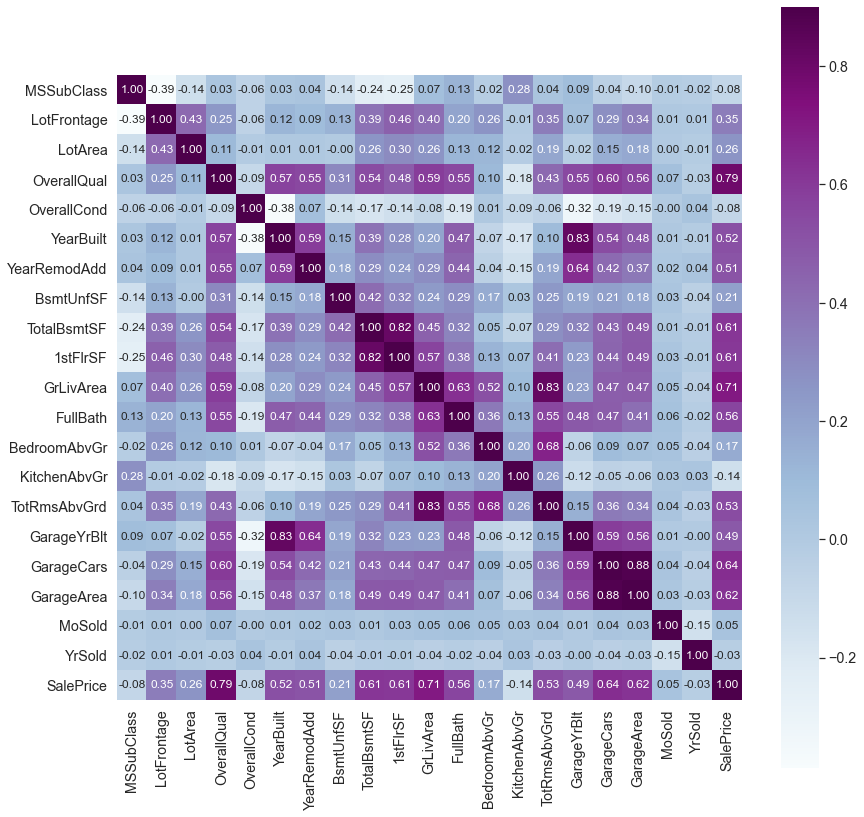

In [20]:
correlation_matrix = numerical_dimensions.corr()
figure, axis = mplplot.subplots(figsize=(14,14))
sb.set(font_scale=1.3)
sb.heatmap(correlation_matrix, vmax=.9, annot=True, square=True, annot_kws={'size': 12}, fmt='.2f', cmap="BuPu")
mplplot.show()

#### Top 10 dimensions that has the most impact on home sale price

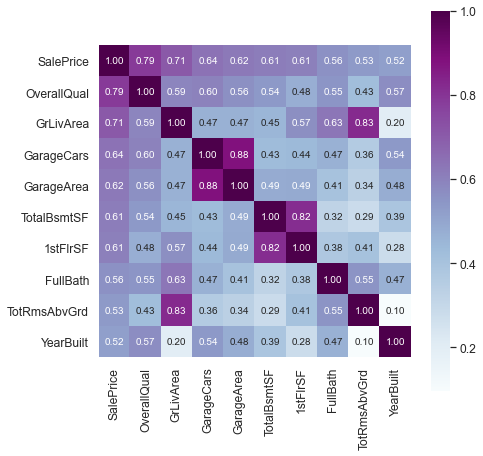

In [23]:
strongly_correlated_dimensions = correlation_matrix.nlargest(10, 'SalePrice')['SalePrice'].index
strong_correlation_matrix = np.corrcoef(numerical_dimensions[strongly_correlated_dimensions].values.T)
figure, axis = mplplot.subplots(figsize=(7,7))
sb.set(font_scale=1.1)
sb.heatmap(strong_correlation_matrix, annot=True, square=True, 
           annot_kws={'size': 10}, fmt='.2f', cmap="BuPu", 
           yticklabels=strongly_correlated_dimensions.values,
           xticklabels=strongly_correlated_dimensions.values)
mplplot.show()

#### Scatter plot for top 7 dimensions that has most impact on sale price